# Siamese network for immage classification

setting google colab and load library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random
import wandb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset

load data

In [3]:

npz = np.load('input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [41]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,:]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])

def plot_image_pair(num_img):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(np.squeeze(train_dataset_loader.dataset.right_dat[num_img]))
    axarr[1].imshow(np.squeeze(train_dataset_loader.dataset.left_dat[num_img]))
    plt.show()
    labels = ['equal','not equal']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(train_dataset_loader.dataset.targets[num_img])])


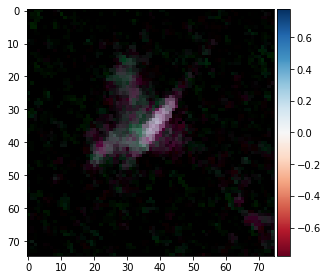

This is: Iceberg


In [ ]:
plot_image(101)

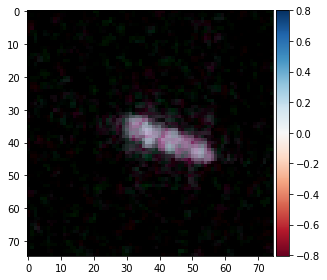

This is: Ship


In [ ]:
plot_image(100)

Create a base Siamese network with He weight initialization

In [10]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.apply(self._init_weights)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5,7,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
        )


        self.fc1=nn.Sequential(
            nn.Linear(2268,18),
            nn.Sigmoid())

        self.out = nn.Linear(18,1)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=torch.sqrt(2/module.in_channels))
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=torch.sqrt(2/module.in_channels))
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=torch.sqrt(2/module.in_channels))
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=torch.sqrt(2/module.in_channels))
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Functions to create the pair dataset and normalize it

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets

In [5]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
    
    return left_input,right_input,targets

Splitting data into training, validation and test set

In [15]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) 

In [24]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [47]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.70),
    transforms.RandomVerticalFlip(0.70),
    transforms.RandomGrayscale(0.70),
    )

Train data

In [7]:
num_workers = 2
bs = 64

In [50]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=transform)


train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)

del image_list_train,label_list_train,train_dataset

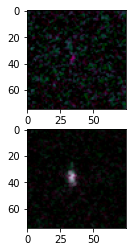

This is: not equal


In [ ]:
plot_image_pair(1)

Validation data

In [ ]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

del image_list_val,label_list_val,validation_dataset

Test data

In [17]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1,shuffle=False, num_workers=2)

del test_dataset

## Train the model

Initialization of the network

In [52]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 2.5e-4 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [28]:
def correct_out(output,label,TrueNegative,FalseNegative,TruePositive,FalsePositive,thresholds):
    for j in range(output.size(0)):
        cos = F.cosine_similarity(output[j],label[j],dim=0)
        if (cos>thresholds) and (label[j]==1):
            TrueNegative+=1
        elif (cos>thresholds) and (label[j]==0):
            FalseNegative+=1
        elif (cos<thresholds) and (label[j]==0):
            TruePositive+=1
        elif (cos<thresholds) and (label[j]==1):
            FalsePositive+=1

    return TrueNegative,FalseNegative,TruePositive,FalsePositive

Train and validate model

In [ ]:
n_epochs = 30

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    TN=0
    FN=0
    TP=0
    FP=0

    ###################
    #   MODEL TRAIN   #
    ###################
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})
    config = wandb.config

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()
        output = net(img0, img1)

        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # stats
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)
       
        bar.set_postfix({"Train loss":loss.item(),
        "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
        "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
        "correct_out":(TN+TP)/total})

    # scheduler
    scheduler.step()
    
    # report stat
    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)
    lr_rate = [param_group['lr'] for param_group in optimizer.param_groups][0]
    train_metrics = {"train/loss": loss.item(),"train/Precision":Pr,"train/Recall":Rec,"train/Jaccard" :Jaccard, 
                       "train/accuracy": Acc,"lr_rate": lr_rate}
    wandb.log({**train_metrics})

    print("Accuracy training loss after {} epochs : {}".format(epoch, Acc))
    ######################   
    #  MODEL VALIDATION  #
    ######################
    net.eval()
    del img0, img1, label, bar
    TN=0
    FN=0
    TP=0
    FP=0

    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            loss = criterion(output, label.unsqueeze(1))
            
            total = label.size(0)
            TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)

            bar.set_postfix({"Validation loss":loss.item(),
            "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
            "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
            "correct_out":(TP+TN)/total})

    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)

    
    val_metrics = {"val/loss": loss.item(),"val/Precision":Pr,"val/Recall":Rec,"val/Jaccard" :Jaccard, 
                       "val/accuracy": Acc}
    wandb.log({**val_metrics})
    
    print("Average validation loss after {} epochs : {}".format(epoch, Acc))


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 1 epochs : 0.5707446808510638


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 1 epochs : 0.6565349544072948


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 2 epochs : 0.6667173252279636


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 2 epochs : 0.7477203647416414


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Accuracy training loss after 3 epochs : 0.6930091185410334


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 3 epochs : 0.7711246200607903


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 4 epochs : 0.7062310030395137


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 4 epochs : 0.7531914893617021


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 5 epochs : 0.7158814589665653


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 5 epochs : 0.7407294832826747


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 6 epochs : 0.7336626139817629


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 6 epochs : 0.7723404255319148


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 7 epochs : 0.7473404255319149


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 7 epochs : 0.7981762917933131


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 8 epochs : 0.7675531914893617


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 8 epochs : 0.786322188449848


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()self

Accuracy training loss after 9 epochs : 0.7827507598784195


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 9 epochs : 0.8063829787234043


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 10 epochs : 0.8093465045592705


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 10 epochs : 0.8209726443768997


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 11 epochs : 0.8277355623100304


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 11 epochs : 0.8410334346504559


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 12 epochs : 0.8503039513677811


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 12 epochs : 0.8528875379939209


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 13 epochs : 0.8649696048632218


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 13 epochs : 0.8474164133738602


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 14 epochs : 0.8886018237082067


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 14 epochs : 0.8629179331306991


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 15 epochs : 0.8987082066869301


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
    Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()self._shutdown_workers()    
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    

if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutd

Average validation loss after 15 epochs : 0.8662613981762918


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Accuracy training loss after 16 epochs : 0.915273556231003


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 16 epochs : 0.8772036474164133


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 17 epochs : 0.9277355623100304


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 17 epochs : 0.8844984802431611


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 18 epochs : 0.9422492401215805


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 18 epochs : 0.8884498480243161


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 19 epochs : 0.9460486322188449


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 19 epochs : 0.8924012158054712


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 20 epochs : 0.9559270516717325


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 20 epochs : 0.8936170212765957


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 21 epochs : 0.956838905775076


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 21 epochs : 0.8993920972644377


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        if w.is_alive():
self._shutdown_workers()  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>    assert self._parent_pid == os.getpid(), 'can only test a child proce

Accuracy training loss after 22 epochs : 0.962386018237082


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 22 epochs : 0.8969604863221885


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 23 epochs : 0.9641337386018237


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 23 epochs : 0.9015197568389057


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 24 epochs : 0.9691489361702128


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 24 epochs : 0.9072948328267477


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 25 epochs : 0.9726443768996961


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 25 epochs : 0.9054711246200607


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 26 epochs : 0.9751519756838906


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 26 epochs : 0.9063829787234042


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 27 epochs : 0.9765197568389058


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 27 epochs : 0.9072948328267477


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b6002b790>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.8/multiprocessing/process.py"

Accuracy training loss after 28 epochs : 0.9774316109422493


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 28 epochs : 0.9091185410334347


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 29 epochs : 0.9781155015197568


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 29 epochs : 0.9085106382978724


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 30 epochs : 0.978951367781155


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 30 epochs : 0.9075987841945289


In [ ]:
#torch.save(net,'net_89')

## Test Siamese network on similarity task

Load the Siamese Network

In [11]:
net = torch.load('net_89',map_location=torch.device('cpu'))

Evaluate on test set

In [55]:
result = []

with torch.no_grad():
    net.eval()
    TN=0
    FN=0
    TP=0
    FP=0
    #del img0, img1, label
    print("Testing...")
    bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})
    config = wandb.config
    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)
 
        if TP > 0:    
          Pr = TP / (TP + FP)
          Rec = TP /(TP + FN)
          Acc = (TP+TN)/(TP + TN + FN + FP)
          Jaccard = TP/(TP + FN + FP) 
        else:
          Pr = 0
          Rec= 0 
          Acc = 0
          Jaccard = 0
        bar.set_postfix(ordered_dict={"Accuracy":(Acc)*100})  
print('{} correct predictions out of {}\nAccuracy : {:.2f}\nJaccard : {:.2f}'.format((TP+TN),(TP+TN+FN+FP), (Acc)*100,Jaccard*100))

Testing...


  0%|          | 0/4115 [00:00<?, ?it/s, Accuracy=0]

3956 correct predictions out of 4115
Accuracy : 96.14
Jaccard : 92.76


## Evaluate model on a classification task

Function to create a dataset that randomly pairs ships with other images, ensuring that the same image is not paired.

In [23]:
def ShipClassification(image_list,label_list, pairs):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
      if label_list[i] == 0: #ships
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            
            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
                
    return left_input,right_input,targets

Create the test data loader

In [24]:
left_dat,right_dat,targets = ShipClassification(image_list = image_list_test,label_list=label_list_test,pairs=15)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1,shuffle=False, num_workers=2)

del image_list_test,label_list_test,test_dataset

Evaluate the classification

In [29]:
with torch.no_grad():
    net.eval()
    TN=0
    FN=0
    TP=0
    FP=0
    #del img0, img1, label
    print("Testing...")
    bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})

    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)

        if TP > 0:    
          Pr = TP / (TP + FP)
          Rec = TP /(TP + FN)
          Acc = (TP+TN)/(TP + TN + FN + FP)
          Jaccard = TP/(TP + FN + FP) 
        else :
          Pr = 0
          Rec = 0
          Acc = 0
          Jaccard = 0 
        bar.set_postfix(ordered_dict={"Accuracy":(Acc)*100})  

    print('{} correct predictions out of {}\nAccuracy : {:.2f}\nJaccard : {:.2f}'.format((TP+TN),(TP+TN+FN+FP), (Acc)*100,Jaccard*100))

Testing...


  0%|          | 0/6195 [00:00<?, ?it/s, Accuracy=0]

5938 correct predictions out of 6195
Accuracy : 95.85
Jaccard : 92.39


## Visualization

Patch cam of two images compared

In [30]:
def extract_patch_cam(net, img_l,img_r, patch_width, patch_height):
    assert not img_l.shape[-2] % patch_height and not img_l.shape[-1] % patch_width
    with torch.no_grad():
        pred = net(img_l,img_r).max(1)[1].item()  
        num_patches_x = img_l.shape[-2] // patch_height
        num_patches_y = img_l.shape[-1] // patch_width
        ret = torch.zeros(1, num_patches_y, num_patches_x)
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                tmp_imgL = img_l.clone()
                tmp_imgR = img_r.clone()
                tmp_imgL[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                tmp_imgR[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                ret[:, i, j] = torch.softmax(net(tmp_imgL,tmp_imgR), dim=1)[0, pred].item()
    ret = 1 - ret
    return ret, pred

Pred: ship
Ground truth: ship


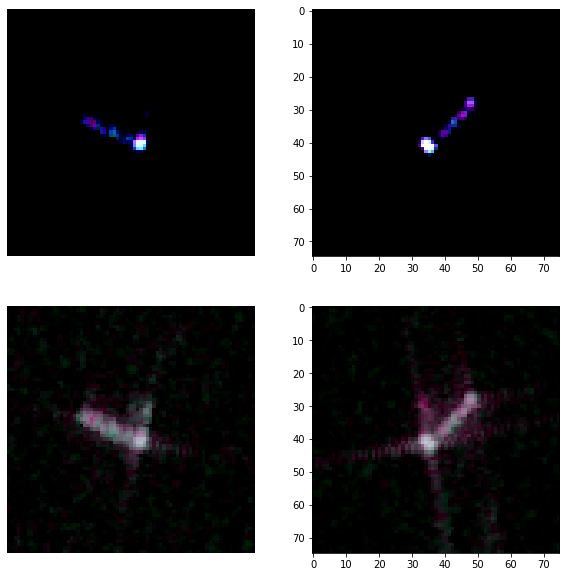

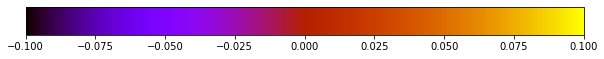

In [36]:
classes = ('ship','iceberg')

idx = 0
patch_width = 5
patch_height = 5

upsample_layer_cpu = torch.nn.Upsample(size=(75, 75), mode='bilinear', align_corners=True).cuda()
data = next(iter(test_dataset_loader))
example_l = upsample_layer_cpu(data[0][idx:idx+1])
example_r = upsample_layer_cpu(data[1][idx:idx+1])
label = data[2][idx:idx+1].item()
heatmap, pred = extract_patch_cam(net, img_l=example_l,img_r=example_r, patch_width=patch_width, patch_height=patch_height)
print(f"Pred: {classes[pred]}")
print(f"Ground truth: {classes[int(label)]}")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2): axes[i,0].axis("off")
axes[0,0].imshow(example_l.cpu()[0].permute(1, 2, 0))
axes[0,1].imshow(example_r.cpu()[0].permute(1, 2, 0))
axes[1,0].imshow(test_dataset_loader.dataset.left_dat[0])
axes[1,1].imshow(test_dataset_loader.dataset.right_dat[0])
#axes[2].imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")